# VIKING/ HSC WIDE run

In this directory we are performing an all band selected processing of VIKING J,H,Ks and HSC G,R,I,Z,Y PDR2 WIDE data.

This was originally only producing files for the XMM W02 field but now produces dictionaries for all fields.

In this notebook we plot the VIKING tiles, over the tracts to patches to check coverages and then create the slurm jobs required to send the jobs to IRIS as arrays. We will also calculate times based on benchmarking on the SXDS field.

We will try to make a job dictionary for each field independently.

In [1]:
# What version of the Stack are we using?
! eups list -s | grep lsst_distrib
! eups list -s | grep obs_vista

lsst_distrib          g0b29ad24fb+cd38383676 	current w_2022_38 w_latest setup
obs_vista             23.0.0-1   	current setup


In [2]:
from astropy.table import Table,Column
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import json

#We are using a rings skymap
from lsst.geom import SpherePoint 
from lsst.geom import degrees
from lsst.skymap.ringsSkyMap import RingsSkyMap, RingsSkyMapConfig

config = RingsSkyMapConfig()
#These config options are chose to be the same as HSC:
#https://github.com/lsst/obs_subaru/blob/master/config/hsc/makeSkyMap.py
config.numRings = 120
config.projection = "TAN"
config.tractOverlap = 1.0/60 
config.pixelScale = 0.168
sm = RingsSkyMap(config)

In [3]:
!ls ../../dmu1/data/

hsc_images_overview.csv
hsc_images_overview_20210315.csv
hsc_images_overview_20210315.csv.old
hsc_images_overview_20220526.csv
vhs_images_overview.csv
vhs_images_overview_20201102.csv
vhs_images_overview_20210409.csv
vhs_images_overview_temp_790000.csv
vhs_tiles_tracts_patches_overview_20201102.csv
video_images_overview.csv
video_images_overview_20200820.csv
video_images_overview_20210322.csv
video_images_overview_20210330.csv
video_images_overview_20210331.csv
video_tiles_tracts_patches_overview_20200820.csv
viking_images_overview_20201218.csv
viking_images_overview_20210406.csv
viking_tiles_tracts_patches_overview_20201218.csv


In [4]:
!ls ../../dmu1/json/

hsc_total_patch_dict.json             vhs_total_patch_dict_20220527.json
hsc_total_patch_dict_20220527.json    video_total_patch_dict.json
hsc_vhs_overlap.json                  video_total_patch_dict_20220527.json
hsc_video_overlap.json                viking_total_patch_dict.json
hsc_viking_overlap.json               viking_total_patch_dict_20220527.json
vhs_total_patch_dict.json


In [5]:
viking_ims = Table.read('../../dmu1/data/viking_images_overview_20210406.csv')
hsc_ims = Table.read('../../dmu1/data/hsc_images_overview_20220526.csv')

In [6]:
viking_total_patch_dict = json.loads(open('../../dmu1/json/viking_total_patch_dict_20220527.json', 'r').read())

In [7]:
!ls -al ../../dmu0/dmu0_HSC/tracts_patches/ 

total 170712
drwxr-xr-x  16 raphaelshirley  staff       512  4 Feb  2022 .
drwxr-xr-x  12 raphaelshirley  staff       384  1 Aug 11:22 ..
-rw-r--r--@  1 raphaelshirley  staff    390454 17 Mar  2021 tracts_patches_DUD-COSMOS.txt
-rw-r--r--@  1 raphaelshirley  staff    432589 17 Mar  2021 tracts_patches_DUD-DEEP2-3.txt
-rw-r--r--@  1 raphaelshirley  staff    392199 17 Mar  2021 tracts_patches_DUD-ELAIS-N1.txt
-rw-r--r--@  1 raphaelshirley  staff    352994 17 Mar  2021 tracts_patches_DUD-XMM-LSS.txt
-rw-r--r--@  1 raphaelshirley  staff    156887  4 Feb  2022 tracts_patches_W-AEGIS.txt
-rw-r--r--@  1 raphaelshirley  staff  26107950  4 Feb  2022 tracts_patches_W-autumn.txt
-rw-r--r--@  1 raphaelshirley  staff   4762372  4 Feb  2022 tracts_patches_W-hectomap.txt
-rw-r--r--@  1 raphaelshirley  staff  18198617  4 Feb  2022 tracts_patches_W-spring.txt
-rw-r--r--@  1 raphaelshirley  staff   1367832 17 Mar  2021 tracts_patches_W-w01.txt
-rw-r--r--@  1 raphaelshirley  staff   3170354 17 Mar  2021 

In [8]:
hsc_bands = ['G', 'R', 'I', 'Z', 'Y']
vista_bands = ['Z', 'Y', 'J', 'H', 'Ks']
#PDR2 files
# patch_files = {
#     'w01':'../../dmu0/dmu0_HSC/tracts_patches/tracts_patches_W-w01.txt',
#     'w02':'../../dmu0/dmu0_HSC/tracts_patches/tracts_patches_W-w02.txt',
#     'w03':'../../dmu0/dmu0_HSC/tracts_patches/tracts_patches_W-w03.txt',
#     'w04':'../../dmu0/dmu0_HSC/tracts_patches/tracts_patches_W-w04.txt',
#     'w05':'../../dmu0/dmu0_HSC/tracts_patches/tracts_patches_W-w05.txt',
# }
#PDR3 files (Aegis and Hectomap in north)
patch_files = {
    'sxds':'../../dmu0/dmu0_HSC/tracts_patches/tracts_patches_DUD-XMM-LSS.txt',
    'spring':'../../dmu0/dmu0_HSC/tracts_patches/tracts_patches_W-spring.txt',
    'autumn':'../../dmu0/dmu0_HSC/tracts_patches/tracts_patches_W-autumn.txt',
}

## 1. Plot the regions and compute tile/patch numbers

In [9]:
viking_ims.add_column(Column(
    data= [t.split('/')[-2] for t in viking_ims['file']],
    name='date'))

In [10]:
def fileToNumObs(filename):
    "Parse the file name to an obsNum"
    numObs = filename.split('_')[1].strip('_st_tl_conf.fit')
    return numObs
viking_ims['numObs'] = [fileToNumObs(f) for f in viking_ims['file']]

In [11]:
hsc_ims['tract'] = [f.split('/')[16] for f in hsc_ims['file']]
hsc_ims['patch'] = [f.split('/')[17] for f in hsc_ims['file']]
hsc_ims['depth'] = [f.split('/')[13] for f in hsc_ims['file']]
hsc_ims['band'] = [f.split('-')[-3] for f in hsc_ims['file']]

In [12]:
hsc_ims[-1]

file,ra_0_0,ra_0_y,ra_x_0,ra_x_y,dec_0_0,dec_0_y,dec_x_0,dec_x_y,size,hash,tract,patch,depth,band
str188,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,str3,str9,str1
"/home/ir-shir1/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu0/dmu0_HSC/data/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr3_wide/deepCoadd-results/HSC-I/9116/0,4/calexp-HSC-I-9116-0,4.fits",nan,nan,nan,nan,nan,nan,nan,nan,0,--,9116,"0,4",pdr3_wide,I


In [13]:
def fileToType(filename):
    filetype = ''
    types = {
        'tile':'_tl.fit',
        'stack':'_st.fit',
    }
    for k,v in types.items():
        #print(k,v)
        if filename.endswith(v):
            filetype = k
  
    return filetype
viking_ims['type'] = [fileToType(f) for f in viking_ims['file']]

In [14]:
"Out of {} files in VIKING there are {} stack images".format(len(viking_ims),np.sum(viking_ims['type']=='stack'))

'Out of 229841 files in VIKING there are 41615 stack images'

In [15]:
tract_lists={}
for field in patch_files:
    f = open(patch_files[field], 'r')
    tracts = set()
    for x in f:
        if x.startswith('Tract'):
            tracts.add(int(x.split(' ')[1]))  
    tract_lists[field]=tracts

In [16]:
tract_lists['sxds']

{8282, 8283, 8284, 8523, 8524, 8525, 8765, 8766, 8767}

In [17]:
sm.generateTract(8524).getVertexList()[0][0].asDegrees() 

36.547003235532756

In [18]:
#These need to be chosen carefully to exclude tiles with low overlap
# lims={ #.     [ra_min, ra_max, dec_min, dec_max]  manually from HSC pages first integer value outside tract
#     'w01':    [14,     24,     -3,      4],  
#     'w02':    [27,     41,     -8,      6],   #XMM
#     'w03':    [125,    163,    -3,      6], 
#     'w04':    [164,    228,    -5,      6], 
#     'w05':    [326,    375,    -3,      8], 
# }
lims={}
for field in patch_files:
    tracts=tract_lists[field]
    lims[field] = [
        np.min([sm.generateTract(t).getVertexList()[1][0].asDegrees() for t in tracts] )-1,#ra min
        np.max([sm.generateTract(t).getVertexList()[0][0].asDegrees() for t in tracts] )+1,#ra max
        np.min([sm.generateTract(t).getVertexList()[0][1].asDegrees() for t in tracts] )-1,#dec min
        np.max([sm.generateTract(t).getVertexList()[2][1].asDegrees() for t in tracts] )+1,#dec max
    ]
    
#stupid hack:
lims['autumn']=[329.,42.,-10.,10.]

In [19]:
lims

{'sxds': [32.37030522386394,
  39.19153691201679,
  -8.53331729340612,
  -1.8787355881605454],
 'spring': [124.08573215640449,
  229.98829524822247,
  -4.070991163028427,
  7.045922643852874],
 'autumn': [329.0, 42.0, -10.0, 10.0]}

## Check the basic numbers

Lets look at how many VIKING stack images there are in each field.

In [20]:
viking_near={}
viking_ims_per_field={}
for field in patch_files:
    #stupid hack
    if lims[field][1] > lims[field][0]:
        viking_near[field] = (
            (viking_ims['ra'] > lims[field][0])
            & (viking_ims['ra'] < lims[field][1])
            & (viking_ims['dec'] > lims[field][2])
            & (viking_ims['dec'] < lims[field][3])
        )
    elif lims[field][1] < lims[field][0]:
        viking_near[field] = (
            ((viking_ims['ra'] > lims[field][0])
            | (viking_ims['ra'] < lims[field][1]))
            & (viking_ims['dec'] > lims[field][2])
            & (viking_ims['dec'] < lims[field][3])
        )

    viking_ims_per_field[field] = viking_ims[viking_near[field]]

    print(
        "Field {}: {} VIKING files, {} stack images.".format(
            field,
            np.sum(viking_near[field]), 
            np.sum(viking_near[field] & (viking_ims['type']=='stack'))
        )
    )

Field sxds: 1665 VIKING files, 306 stack images.
Field spring: 103252 VIKING files, 19291 stack images.
Field autumn: 1665 VIKING files, 306 stack images.


Only Viking images in SXDS part of Autumn field!

In [21]:
len(viking_near['sxds']& (viking_ims['type']=='stack'))

229841

In [22]:
"Total VIKING stacks near HSC: {}".format(
    np.sum([np.sum(viking_near[f]& (viking_ims['type']=='stack')) for f in patch_files])
)

'Total VIKING stacks near HSC: 19903'

In [23]:
"There are {} stack files across the whole sky".format(np.sum(viking_ims['type']=='stack'))

'There are 41615 stack files across the whole sky'

In [24]:
viking_ims['ESOGRADE'] = viking_ims['ESOGRADE'].filled()
viking_ims['OBSTATUS'] = viking_ims['OBSTATUS'].filled()

In [25]:
for obstatus in np.unique(viking_ims['OBSTATUS']):

    print("{} stacks with OBSTATUS={}".format(
        np.sum((viking_ims['type']=='stack')&(viking_ims['OBSTATUS']==obstatus)),
        obstatus
    ))

2099 stacks with OBSTATUS=Aborted
31131 stacks with OBSTATUS=Completed
3702 stacks with OBSTATUS=Executed
96 stacks with OBSTATUS=Must Repea
4587 stacks with OBSTATUS=N/A


In [26]:
for esograde in np.unique(viking_ims['ESOGRADE']):

    print("{} stacks with ESOGRADE={}".format(
        np.sum((viking_ims['type']=='stack')&(viking_ims['ESOGRADE']==esograde)),
        esograde
    ))

22228 stacks with ESOGRADE=A
6914 stacks with ESOGRADE=B
3702 stacks with ESOGRADE=C
1989 stacks with ESOGRADE=D
4587 stacks with ESOGRADE=N
2099 stacks with ESOGRADE=R
96 stacks with ESOGRADE=X


In [27]:
np.unique(viking_ims[~viking_ims['filter'].mask]['filter'])

H
J
Ks
Y
Z


/var/folders/l2/pxknhjd1029ckt57_p03cm080000gn/T/ipykernel_26696/3908325579.py:40: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('./figs/viking_seeing_hist.pdf', overwrite=True, bbox_inches='tight')
/var/folders/l2/pxknhjd1029ckt57_p03cm080000gn/T/ipykernel_26696/3908325579.py:41: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('./figs/viking_seeing_hist.png', overwrite=True, bbox_inches='tight')


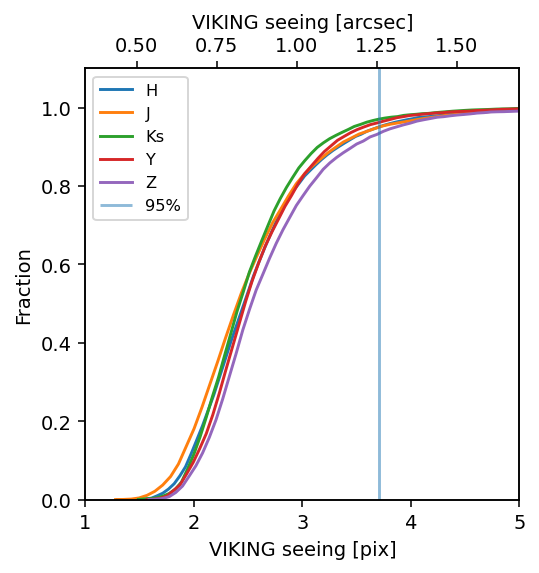

In [28]:
fig = plt.figure(figsize=(4, 4), dpi=140)
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
x_lims=[1,5]
pixwidth=0.339
#hist=np.histogram(video_ims[near_sxds]['SEEING'],bins=100)
#X=[np.mean([hist[1][n],hist[1][n+1]]) for n in np.arange(len(hist[1])-1)] 
#Y=hist[0]
for band in np.unique(viking_ims[~viking_ims['filter'].mask]['filter']):

    #print(band)
    m = (viking_ims['SEEING']>0) & (viking_ims['filter']==band)


    hist=np.histogram(viking_ims[m]['SEEING'],bins=100)
    bin_edges=hist[1]
    bin_middles = (bin_edges[1:] + bin_edges[:-1])/2
    cum_sum=np.cumsum(hist[0])/np.sum(hist[0])
    ax1.plot(bin_middles,cum_sum,label=band)

    ax1.set_ylim([0,1.1])
    ax1.set_xlabel(r"VIKING seeing [pix]")
    ax1.set_xlim(x_lims)
    ax1.set_ylabel('Fraction')
    

seeing_p95=np.nanpercentile(viking_ims['SEEING'],95)
ax1.vlines(seeing_p95,0,1.1,alpha=0.5,label='95%')
ax1.legend(fontsize='small')

new_tick_locations = np.array([0.5,0.75,1,1.25,1.5])/pixwidth
def tick_function(X):
    V = X*pixwidth
    return ["%.2f" % z for z in V]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"VIKING seeing [arcsec]")
fig.savefig('./figs/viking_seeing_hist.pdf', overwrite=True, bbox_inches='tight')
fig.savefig('./figs/viking_seeing_hist.png', overwrite=True, bbox_inches='tight')

/var/folders/l2/pxknhjd1029ckt57_p03cm080000gn/T/ipykernel_26696/3278636899.py:40: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('./figs/viking_zp_hist.pdf', overwrite=True, bbox_inches='tight')
/var/folders/l2/pxknhjd1029ckt57_p03cm080000gn/T/ipykernel_26696/3278636899.py:41: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('./figs/viking_zp_hist.png', overwrite=True, bbox_inches='tight')


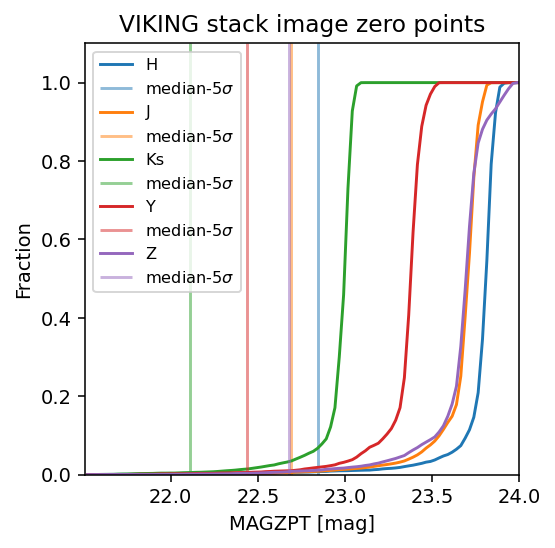

In [29]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=140)

x_lims=[
    np.nanpercentile(viking_ims['MAGZPT'],0.1),
    np.nanpercentile(viking_ims['MAGZPT'],99.9)+0.5
]
x_lims=[21.51,24.]
ax.set_title('VIKING stack image zero points')
for band in np.unique(viking_ims[~viking_ims['filter'].mask]['filter']):

    #print(band)
    m = (viking_ims['SEEING']>0) & (viking_ims['filter']==band)


    zp_p1_band=np.nanpercentile(viking_ims[m]['MAGZPT'],1)
    
    med = np.nanmedian(viking_ims[m]['MAGZPT'])
    std = np.nanstd(viking_ims[m]['MAGZPT'])


    hist=np.histogram(viking_ims[m]['MAGZPT'],bins=100,range=x_lims)
    bin_edges=hist[1]
    bin_middles = (bin_edges[1:] + bin_edges[:-1])/2
    cum_sum=np.cumsum(hist[0])/np.sum(hist[0])
    line=ax.plot(bin_middles,cum_sum,label=band)
    ax.vlines(med-5*std,0,1.1,colors=line[0].get_color(),alpha=0.5,label='median-5$\sigma$')

    
    ax.set_xlabel(r"Seeing [pix]")
    
    ax.set_ylabel('Fraction')
 
ax.set_ylim([0,1.1])
ax.set_xlim(x_lims)

ax.set_xlabel(r"MAGZPT [mag]")
#ax.set_xlim(lims)
ax.set_ylabel('Fraction')
ax.legend(fontsize='small')
fig.savefig('./figs/viking_zp_hist.pdf', overwrite=True, bbox_inches='tight')
fig.savefig('./figs/viking_zp_hist.png', overwrite=True, bbox_inches='tight')

In [30]:
m = viking_ims['type']=='stack'
zpt_mask=m
for band in np.unique(viking_ims[~viking_ims['filter'].mask]['filter']):

    #print(band)
    band_mask= (viking_ims['filter']==band)
    zp_p1_band=np.nanpercentile(viking_ims[band_mask]['MAGZPT'],1)
    
    med = np.nanmedian(viking_ims[band_mask]['MAGZPT'])
    std = np.nanstd(viking_ims[band_mask]['MAGZPT'])
    
    # Use first percentile as mask
    #zpt_mask=(band_mask & (video_ims['MAGZPT']>zp_p1_band)) | (~band_mask & zpt_mask)
    # Use 5 standard deviations below median as mask
    zpt_mask=(
        (band_mask & (viking_ims['MAGZPT']>med - 5*std)) 
        #|(band_mask & (np.isnan(viking_ims['MAGZPT'])) #if magzpt is nan should be because there are no stacks
        | (~band_mask & zpt_mask)
    )
    
seeing_lim = 5 #pixels
print(
    np.sum(m),
    np.sum( m&(zpt_mask)),
    np.sum( (zpt_mask) & (viking_ims['SEEING']<seeing_lim)),
    np.sum(
        (zpt_mask) 
        & (viking_ims['SEEING']<seeing_lim) 
        & (viking_ims['OBSTATUS']=='Completed')
    ),
    np.sum(
        (zpt_mask) 
        & (viking_ims['SEEING']<seeing_lim) 
        & (viking_ims['OBSTATUS']=='Completed')
        & (viking_ims['ESOGRADE']=='A')
    ),
    np.sum(
        (viking_ims['SEEING']<seeing_lim) 
        & ~((viking_ims['OBSTATUS']=='Must Repea')|(viking_ims['OBSTATUS']=='Aborted'))
    ),
    np.sum(
        (zpt_mask) 
        & (viking_ims['SEEING']<seeing_lim) 
        & (
            (viking_ims['ESOGRADE']=='A')
            |(viking_ims['ESOGRADE']=='B')
            |(viking_ims['ESOGRADE']=='C')
            |(viking_ims['ESOGRADE']=='N'))
    )
)

41615 41301 41054 30971 22146 39214 37051


In [31]:
good = (
    (zpt_mask) 
    & (viking_ims['SEEING']<seeing_lim) 
    & ~((viking_ims['OBSTATUS']=='Must Repea')|(viking_ims['OBSTATUS']=='Aborted'))
)
print("Keeping {} percent".format(round(100*np.sum(good)/np.sum(viking_ims['type']=='stack'),2)))

Keeping 93.71 percent


## Plot the VIKING/Wide fields to check coverage

### Patches to run

Lets get the total overlap of patches in HSC that are also in any VIKING tile

mkdir: figs: File exists


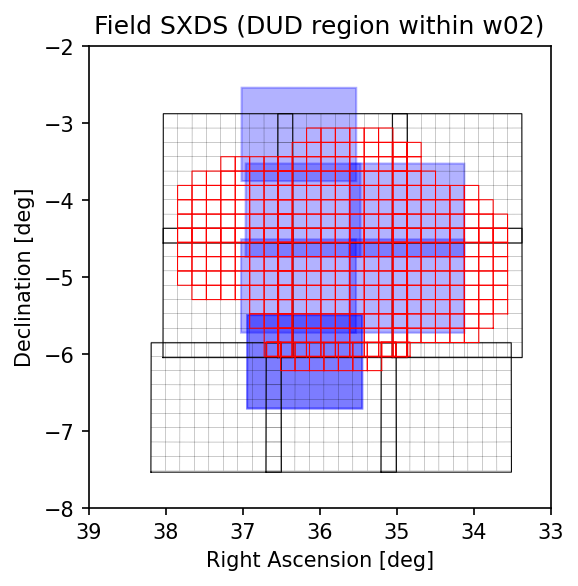

In [32]:
!mkdir figs

fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
field = 'sxds'

#Get official list of tracts that define field
f = open(patch_files[field], 'r')
tracts = set()
for x in f:
    if x.startswith('Tract'):
        tracts.add(int(x.split(' ')[1]))  
full_patch_dict = {}
band_dict = { hsc_bands[i]: {} for i in range(len(hsc_bands))}
for tract in tracts:
    full_patch_dict[tract] = [
        s for s in np.unique(
            np.array(
                hsc_ims[ 
                    (hsc_ims['tract'] == str(tract))
                    & (hsc_ims['depth'] == 'pdr3_dud')                        
                ]['patch'])
        )
    ]
    for band in hsc_bands:
        band_dict[band][tract] = [
            s for s in np.unique(np.array(hsc_ims[
                (hsc_ims['tract'] == str(tract))
                & (hsc_ims['band'] == band)
            ]['patch']))
        ]

#Plot all the tracts and patchs as a grey background        
for tract in tracts:
    vertices = sm.generateTract(tract).getVertexList()
    ra = [vertices[n][0].asDegrees() for n in np.mod(np.arange(5),4)]
    dec = [vertices[n][1].asDegrees() for n in np.mod(np.arange(5),4)]
    ax.plot(ra, dec, c = 'k', linewidth=0.5)
    for p in np.nditer(np.meshgrid(np.arange(0,9), np.arange(0,9))):
        #print(p[0], p[1])
        t = sm.generateTract(tract)
        vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
        ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
        #print(tract, ra)
        dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
        ax.plot(ra, dec, c = 'k', alpha=0.5, linewidth=0.1)

#Plot patches that have HSC files on a band
band = 'all'
if band != 'all':
    d = band_dict[band]
else:
    d = full_patch_dict
for tract in d:
    for patch in d[tract]:
        #print(p[0], p[1])
        p = [int(i) for i in patch.split(',')]
        t = sm.generateTract(tract)
        vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
        ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
        #print(tract, ra)
        dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
        ax.plot(ra, dec, c = 'r', alpha=1.0, linewidth=0.5)


v_band ='Ks' #& (viking_ims['filter'] == v_band)
for t in viking_ims[viking_near[field] & (viking_ims['type'] == 'tile') & (viking_ims['filter'] == v_band) ]:

    ra = [t['ra_0_0'], t['ra_x_0'] , t['ra_x_y'] , t['ra_0_y'] , t['ra_0_0'] ]
    dec = [t['dec_0_0'], t['dec_x_0'] , t['dec_x_y'] , t['dec_0_y'] , t['dec_0_0'] ]

    ax.fill(ra,dec, c = 'b', alpha=0.3)



ax.set_title("Field SXDS (DUD region within w02)")
ax.axis('scaled')
ax.set_xlim([39, 33])
ax.set_ylim([-8, -2])
ax.set_xlabel('Right Ascension [deg]')
ax.set_ylabel('Declination [deg]')
plt.show()
fig.savefig('./figs/{}_HSC-{}_DUD_tracts.pdf'.format(field,band))
fig.savefig('./figs/{}_HSC-{}_DUD_tracts.png'.format(field,band))

Field: spring


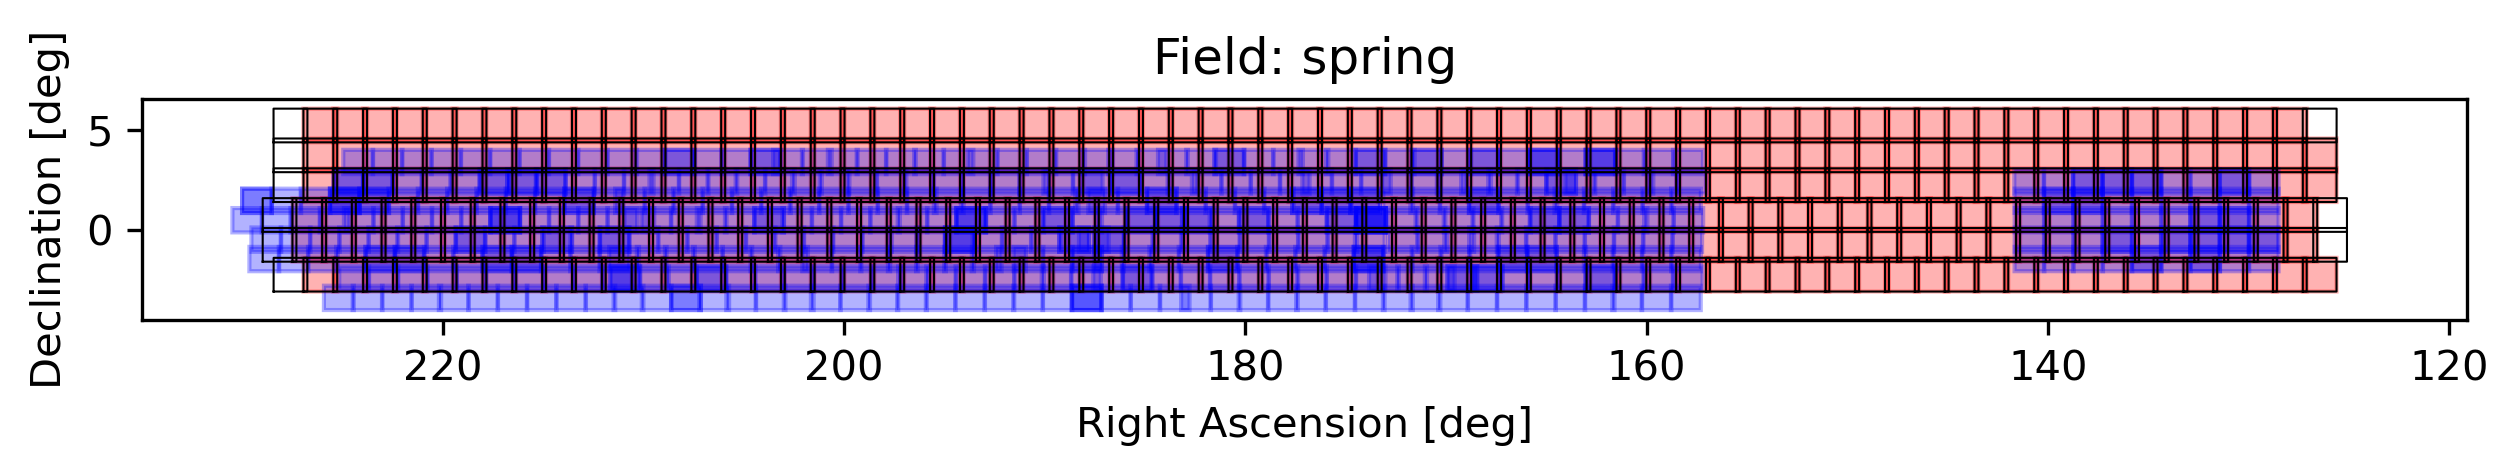

Field: autumn


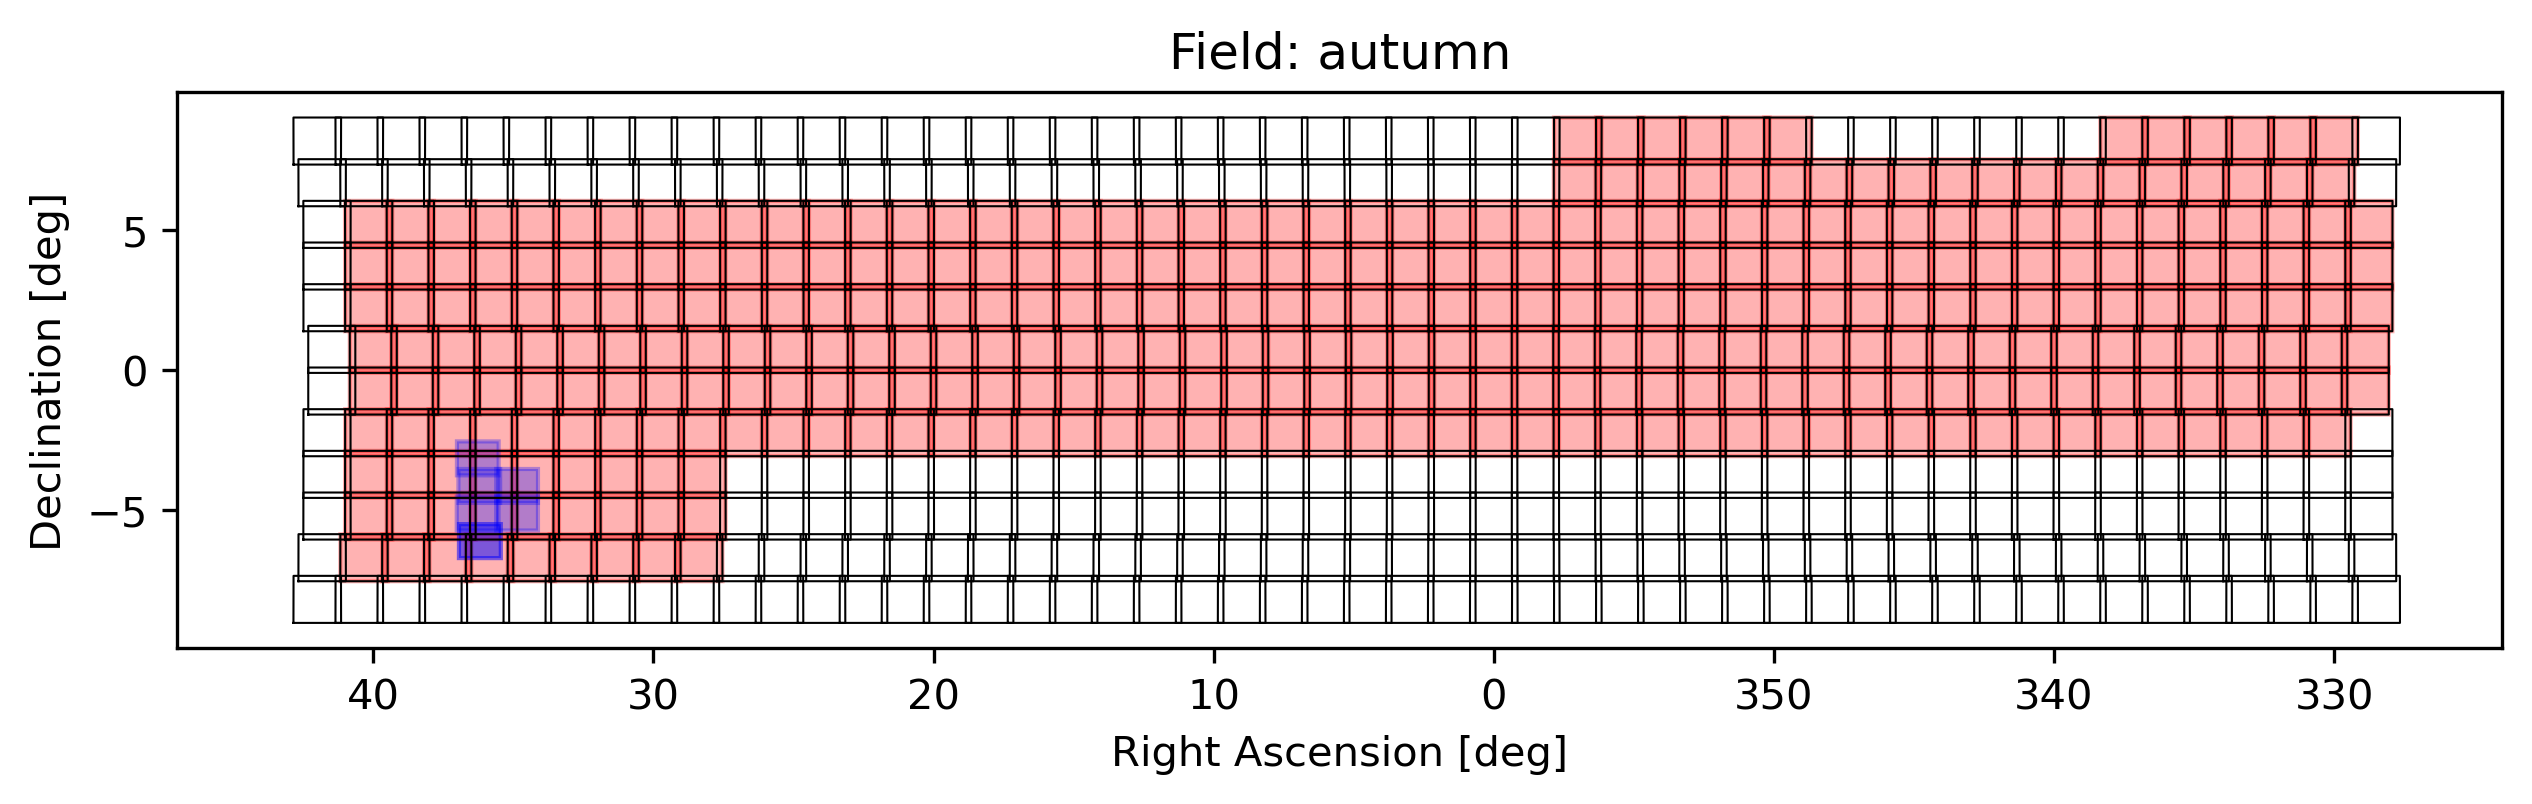

In [33]:
for field in patch_files:
    if field=='sxds':
        continue
    fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
    print('Field: {}'.format(field))
    #Get official list of tracts that define field
    f = open(patch_files[field], 'r')
    tracts = set()
    for x in f:
        if x.startswith('Tract'):
            tracts.add(int(x.split(' ')[1]))  
    full_patch_dict = {}
    band_dict = { hsc_bands[i]: {} for i in range(len(hsc_bands))}
    for tract in tracts:
        full_patch_dict[tract] = [
            s for s in np.unique(np.array(hsc_ims[ (hsc_ims['tract'] == str(tract))]['patch']))
        ]
        for band in hsc_bands:
            band_dict[band][tract] = [
                s for s in np.unique(np.array(hsc_ims[
                    (hsc_ims['tract'] == str(tract))
                    & (hsc_ims['band'] == band)
                ]['patch']))
            ]

    #Plot all the tracts and patchs as a grey background        
    for tract in tracts:
        vertices = sm.generateTract(tract).getVertexList()
        ra = [vertices[n][0].asDegrees() for n in np.mod(np.arange(5),4)]
        for i in np.arange(5):
            if ra[i]<100:
                ra[i] = ra[i]+360
        dec = [vertices[n][1].asDegrees() for n in np.mod(np.arange(5),4)]
        ax.plot(ra, dec, c = 'k', linewidth=0.5)


    #Plot tracts?patches that have HSC files on a band
    band = 'all'
    if band != 'all':
        d = band_dict[band]
    else:
        d = full_patch_dict
    for tract in d:
        if  len(d[tract])==0:
            continue
        vertices = sm.generateTract(tract).getVertexList()
        ra = [vertices[n][0].asDegrees() for n in np.mod(np.arange(5),4)]
        for i in np.arange(5):
            if ra[i]<100:
                ra[i] = ra[i]+360
        dec = [vertices[n][1].asDegrees() for n in np.mod(np.arange(5),4)]
        ax.fill(ra, dec, c = 'r', alpha=0.3)



    v_band ='Ks'
    for t in viking_ims[viking_near[field] & (viking_ims['type'] == 'tile') & (viking_ims['filter'] == v_band) ]:

        ra = [t['ra_0_0'], t['ra_x_0'] , t['ra_x_y'] , t['ra_0_y'] , t['ra_0_0'] ]
        dec = [t['dec_0_0'], t['dec_x_0'] , t['dec_x_y'] , t['dec_0_y'] , t['dec_0_0'] ]
        for i in np.arange(5):
            if ra[i]<100:
                ra[i] = ra[i]+360
        ax.fill(ra,dec, c = 'b', alpha=0.3)



    ax.set_title("Field: {}".format(field))
    ax.axis('scaled')
    if lims[field][1] < 100:
        ax.set_xlim([lims[field][1]+360+5, lims[field][0]-5])
        ticks=[int(t) for t in np.linspace(400,330,8)]
        ticklabels=[t if t <360 else t-360 for t in ticks]
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticklabels)
    elif lims[field][1] > 100:
        ax.set_xlim([lims[field][1]+5, lims[field][0]-5])
    ax.set_xlabel('Right Ascension [deg]')
    ax.set_ylabel('Declination [deg]')
    plt.show()
    fig.savefig('./figs/{}_HSC-{}_tracts.pdf'.format(field,band))
    fig.savefig('./figs/{}_HSC-{}_tracts.png'.format(field,band))

In [34]:
#How many diferent exposure times for stacks are there
np.unique(viking_ims[(viking_ims['type'] == 'stack')  ]['exptime'])

0
1
10
25
60


## 1. Make the image job dictionaries

We will now create a dictionary mapping integer 0 indexed job ids to job options to reduce the number of slurm files required. This dictionary can then be saved as a json file and passed to the bash script which runs the process. We may wish to move to pure Python to make this more tidy. 

In [35]:
print(
    np.min([int(d) for d in viking_ims[(viking_ims['type'] == 'stack')]['date']]), 
    np.max([int(d) for d in viking_ims[(viking_ims['type'] == 'stack')]['date']])
)

20091112 20180214


In [36]:
def raDecToTractSafe(ra,dec):
    """Return all the tracts within 2 degrees of a ra dec to get every tract covering a tile
    
    I think the function findTractPatchList excludes all tracts that do not conatin the points
    Crucially this excluded the central tracts. Perhaps we need to get the corners from the tile.
    
    """
    size = 2 #degrees safely outside tile from centre
    patches= sm.findTractPatchList([
        SpherePoint((ra)*degrees,(dec)*degrees)
        for ra, dec in np.nditer(
            np.meshgrid(
                np.linspace(ra+size,ra-size,num=int(size/0.5)),
                np.linspace(dec+size,dec-size,num=int(size/0.5)),
            )
        )
    ])
    tracts = set([p[0].getId() for p in patches])
    t =''
    for n in tracts:
        t += '^{}'.format(n)
    return t[1:]
    
print(
    viking_ims[(viking_ims['type'] == 'stack')][0]['ra'], 
    viking_ims[(viking_ims['type'] == 'stack')][0]['dec'],
    raDecToTractSafe(
        viking_ims[(viking_ims['type'] == 'stack')][0]['ra'],
        viking_ims[(viking_ims['type'] == 'stack')][0]['dec']
    )
)

42.299883 -33.47474 4422^4423^4424^4425^4016^4017^4018^4019^4218^4219^4220


In [37]:
for field in patch_files:
    
    images_job_dict = {}
 
    ims_to_run=viking_ims[viking_near[field] & (viking_ims['type']=='stack') & good]
    n = len(ims_to_run)
    #Run over every stack image in the field
    for i in np.arange(n):
        date=ims_to_run[i]['date']
        images_job_dict[str(i)] = [
            '{}-{}-{}'.format(date[0:4],date[4:6],date[6:9]),
            ims_to_run[i]['numObs'],
            'VISTA-{}'.format(ims_to_run[i]['filter']),
            raDecToTractSafe(ims_to_run[i]['ra'],ims_to_run[i]['dec']),
            ims_to_run[i]['file'],
            int(ims_to_run[i]['visit']),
        ]
    dict_name ='./slurm/{}_images_job_dict_{}.json'.format(field,n)
    if n==0:
        print('Field {}: {} patches, no dict written'.format(field,n))
        continue
    print('Field {}: {} images, dict written to {}'.format(field,n,dict_name))
    with open(dict_name, 'w') as outfile:
        json.dump(images_job_dict, outfile, separators=(',', ':'))

Field sxds: 254 images, dict written to ./slurm/sxds_images_job_dict_254.json
Field spring: 18236 images, dict written to ./slurm/spring_images_job_dict_18236.json
Field autumn: 254 images, dict written to ./slurm/autumn_images_job_dict_254.json


In [38]:
images_job_dict = {}
in_fields = np.full(len(viking_ims),False)
for field in patch_files:

    in_fields |=viking_near[field]
ims_to_run=viking_ims[in_fields & (viking_ims['type']=='stack')& good]
n = len(ims_to_run)
#Run over every stack image in the field
for i in np.arange(n):
    date=ims_to_run[i]['date']
    images_job_dict[str(i)] = [
        '{}-{}-{}'.format(date[0:4],date[4:6],date[6:9]),
        ims_to_run[i]['numObs'],
        'VISTA-{}'.format(ims_to_run[i]['filter']),
        raDecToTractSafe(ims_to_run[i]['ra'],ims_to_run[i]['dec']),
        ims_to_run[i]['file'],
        int(ims_to_run[i]['visit']),
    ]
dict_name ='./slurm/full_images_job_dict_{}.json'.format(n)
print('Total: {} images, dict written to {}'.format(n,dict_name))
with open(dict_name, 'w') as outfile:
    json.dump(images_job_dict, outfile, separators=(',', ':'))

Total: 18490 images, dict written to ./slurm/full_images_job_dict_18490.json


# 2. Make the patch job array dictionaries

For each field we want the patches that are in HSC and have VIKING coverage.

In [39]:
full_patch_job_dict={}
n_full=0
for field in patch_files:
    tracts = set()
    for x in open(patch_files[field], 'r'):
        if x.startswith('Tract'):
            tracts.add(int(x.split(' ')[1]))  
    

    hsc_patch_dict = {}
    viking_patch_dict = {}
    patch_job_dict = {}
    n=0
    for tract in tracts:
        hsc_patch_dict[tract] = [
            s for s in np.unique(np.array(hsc_ims[ (hsc_ims['tract'] == str(tract))]['patch']))
        ]
        try:
            viking_patch_dict[tract] = ["{},{}".format(p[0],p[1]) for p in viking_total_patch_dict[str(tract)]]
        except KeyError:
            viking_patch_dict[tract] = []
        for patch in np.nditer(np.meshgrid(np.arange(9),np.arange(9))):
            patch="{},{}".format(patch[0],patch[1])
            #check if patch is in both regions
            in_hsc = patch in hsc_patch_dict[tract]
            in_viking = patch in viking_patch_dict[tract]
            if in_hsc and in_viking:
                patch_job_dict[str(n)]=[tract, patch ]
                full_patch_job_dict[str(n_full)]=[tract, patch ]
                n+=1
                n_full+=1
    
   
    
    
    dict_name ='./slurm/{}_patch_job_dict_{}.json'.format(field,n)
    if n==0:
        print('Field {}: {} patches, no dict written'.format(field,n))
        continue
    print('Field {}: {} patches, dict written to {}'.format(field,n,dict_name))
    with open(dict_name, 'w') as outfile:
        json.dump(patch_job_dict, outfile, separators=(',', ':'))

Field sxds: 356 patches, dict written to ./slurm/sxds_patch_job_dict_356.json
Field spring: 19463 patches, dict written to ./slurm/spring_patch_job_dict_19463.json
Field autumn: 386 patches, dict written to ./slurm/autumn_patch_job_dict_386.json


In [40]:
dict_name ='./slurm/full_patch_job_dict_{}.json'.format(n_full)

print('Total: {} patches, dict written to {}'.format(n_full,dict_name))
with open(dict_name, 'w') as outfile:
    json.dump(full_patch_job_dict, outfile, separators=(',', ':'))

Total: 20205 patches, dict written to ./slurm/full_patch_job_dict_20205.json


In [41]:
#Make list of tracts for BPS file SQL (don't worry about partially covered tracts)
full_tract_list=set()
for n in full_patch_job_dict:
    full_tract_list=full_tract_list.union(set([full_patch_job_dict[n][0]]))
",".join([str(t) for t in full_tract_list])

'8283,8284,9313,9314,9315,9316,9317,9318,9319,9320,9321,9322,9332,9333,9334,9335,9336,9337,9338,9339,9340,9341,9342,9343,9344,9345,9346,9347,9348,9349,9350,9351,9352,9353,9354,9355,9356,9357,9358,9359,9360,9361,9362,9363,9364,9365,9366,9367,9368,9369,9370,9371,9372,9373,9374,9375,9376,9377,9378,9379,8523,8524,8525,9556,9557,9558,9559,9560,9561,9562,9563,9564,9565,9575,9576,9577,9578,9579,9580,9581,9582,9583,9584,9585,9586,9587,9588,9589,9590,9591,9592,9593,9594,9595,9596,9597,9598,9599,9600,9601,9602,9603,9604,9605,9606,9607,9608,9609,9610,9611,9612,9613,9614,9615,9616,9617,9618,9619,9620,9621,9622,8765,8766,8767,9798,9799,9800,9801,9802,9803,9804,9805,9806,9807,9817,9818,9819,9820,9821,9822,9823,9824,9825,9826,9827,9828,9829,9830,9831,9832,9833,9834,9835,9836,9837,9838,9839,9840,9841,9842,9843,9844,9845,9846,9847,9848,9849,9850,9851,9852,9853,9854,9855,9856,9857,9858,9859,9860,9861,9862,9863,9864,10105,10106,9008,9009,10040,10041,10042,10043,10044,10045,10046,10047,10048,10049,10059,1

In [42]:
len(full_tract_list)

299

## eFeds field

An early test of the pipeline will be on the eFeds field so here I am going to make input files just for that region.

Region limits taken from figure 1 in:

https://www.aanda.org/articles/aa/pdf/2022/05/aa41266-21.pdf

In [43]:
efeds_lims = [126,146,-3,6]
field='eFeds'

In [44]:
inEFeds=(
    (viking_ims['ra']>efeds_lims[0]-1)
    & (viking_ims['ra']<efeds_lims[1]+1)
    & (viking_ims['dec']>efeds_lims[2]-1)
    & (viking_ims['dec']<efeds_lims[3]+1)
)

In [45]:
np.sum(inEFeds)

11187

In [46]:
np.sum(inEFeds & (viking_ims['type']=='stack') & good)

1802

In [47]:
images_job_dict = {}

ims_to_run=viking_ims[inEFeds & (viking_ims['type']=='stack') & good]
n = len(ims_to_run)
#Run over every stack image in the field
for i in np.arange(n):
    date=ims_to_run[i]['date']
    images_job_dict[str(i)] = [
        '{}-{}-{}'.format(date[0:4],date[4:6],date[6:9]),
        ims_to_run[i]['numObs'],
        'VISTA-{}'.format(ims_to_run[i]['filter']),
        raDecToTractSafe(ims_to_run[i]['ra'],ims_to_run[i]['dec']),
        ims_to_run[i]['file']
    ]
dict_name ='./slurm/{}_images_job_dict_{}.json'.format(field,n)
if n==0:
    print('Field {}: {} patches, no dict written'.format(field,n))
print('Field {}: {} images, dict written to {}'.format(field,n,dict_name))
with open(dict_name, 'w') as outfile:
    json.dump(images_job_dict, outfile, separators=(',', ':'))

Field eFeds: 1802 images, dict written to ./slurm/eFeds_images_job_dict_1802.json


We don't actually need a patch dict we just need the tracts for the DRP yaml file

In [48]:

tracts = set()
for x in open(patch_files['spring'], 'r'):
    if x.startswith('Tract'):
        tracts.add(int(x.split(' ')[1]))  


hsc_patch_dict = {}
viking_patch_dict = {}
patch_job_dict = {}
n=0
for tract in tracts:
    t=sm.generateTract(tract)
    
    if t.ctr_coord[0].asDegrees() > 150:
        continue
    #print(tract,ra,dec,t.ctr_coord[0].asDegrees(),t.ctr_coord[1].asDegrees())
    hsc_patch_dict[tract] = [
        s for s in np.unique(np.array(hsc_ims[ (hsc_ims['tract'] == str(tract))]['patch']))
    ]
    try:
        viking_patch_dict[tract] = ["{},{}".format(p[0],p[1]) for p in viking_total_patch_dict[str(tract)]]
    except KeyError:
        continue
        #viking_patch_dict[tract] = []
    for patch in np.nditer(np.meshgrid(np.arange(9),np.arange(9))):
        patch="{},{}".format(patch[0],patch[1])
        #check if patch is in both regions
        in_hsc = patch in hsc_patch_dict[tract]
        in_viking = patch in viking_patch_dict[tract]
        
        vertices = t.getPatchInfo([int(patch[0]),int(patch[2])]).getInnerSkyPolygon(t.getWcs()).getVertices()
        ra = np.arctan(vertices[0][1]/vertices[0][0])* 180/np.pi 
        if ra <0:
            ra=ra+180
        dec = (vertices[0][2])* 180/np.pi 
        
        in_efeds = (
            (ra>efeds_lims[0])
            &(ra<efeds_lims[1])
            &(dec>efeds_lims[2])
            &(dec<2.1)
        )
        #print(ra,dec,in_efeds)
        if in_hsc and in_viking and in_efeds:
            patch_job_dict[str(n)]=[tract, patch ]

            n+=1
        
    #break



dict_name ='./slurm/{}_patch_job_dict_{}.json'.format(field,n)
if n==0:
    print('Field {}: {} patches, no dict written'.format(field,n))

print('Field {}: {} patches, dict written to {}'.format(field,n,dict_name))
with open(dict_name, 'w') as outfile:
    json.dump(patch_job_dict, outfile, separators=(',', ':'))

Field eFeds: 2106 patches, dict written to ./slurm/eFeds_patch_job_dict_2106.json


In [49]:
efeds_patches={}
tracts=set([patch_job_dict[n][0] for n in patch_job_dict])
for t in tracts:
    efeds_patches[t]=set()
for job in patch_job_dict:
    patch=int(patch_job_dict[job][1][0])+9*int(patch_job_dict[job][1][2])
    efeds_patches[patch_job_dict[job][0]]=efeds_patches[patch_job_dict[job][0]].union(set([patch]))
    


In [50]:
#Don't worry about half full tracts:
"tract IN ({})".format(",".join([str(t) for t in efeds_patches]))

'tract IN (9798,9799,9800,9801,9802,9803,9804,9805,9806,9807,9556,9557,9558,9559,9560,9561,9562,9563,9564,9565,9313,9314,9315,9316,9317,9318,9319,9320,9321,9322,9070,9071,9072,9073,9074,9075,9076,9077,9078,9079)'

In [51]:
#Do worry about half full tracts
full_tracts=[]
for t in efeds_patches:
    patches=efeds_patches[t]
    if len(patches)==81:
        full_tracts.append(t)
print("tract IN ({})".format(",".join([str(t) for t in full_tracts])))
for t in efeds_patches:
    patches=efeds_patches[t]
    if len(patches)<81:
        print("OR (tract={tract} AND patch IN ({patches}))".format(tract=t,patches=",".join([str(p) for p in patches])))

tract IN (9557,9558,9559,9560,9561,9562,9563,9564,9314,9315,9316,9317,9318,9319,9320,9321)
OR (tract=9798 AND patch IN (0,1,18,19,9,10,27,28))
OR (tract=9799 AND patch IN (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35))
OR (tract=9800 AND patch IN (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35))
OR (tract=9801 AND patch IN (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35))
OR (tract=9802 AND patch IN (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35))
OR (tract=9803 AND patch IN (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35))
OR (tract=9804 AND patch IN (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35))
OR (tract=9805 AND patch IN (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,2